In [88]:
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, log_loss
import optuna
import seaborn as sns

In [89]:
# load in 2022 mlb season data

df = pd.read_csv(r"Y:\departments\research_and_development\baseball_operations\clayton_goodiez\csv\2023_processed.csv")

# load in 2023 mlb season data

df_2023 = pd.read_csv(r"Y:\departments\research_and_development\baseball_operations\clayton_goodiez\csv\2022_processed.csv")

In [90]:
# load in linear weights for events

linear_weights = pd.read_csv(r"Y:\departments\research_and_development\baseball_operations\clayton_goodiez\csv\linear_weights.csv")

In [91]:
# load in calculated expected metrics

xpfx_x = pd.read_csv(r"Y:\departments\research_and_development\baseball_operations\clayton_goodiez\csv\fastball\pfx_2022&3_xpfx.csv")
xpfx_z = pd.read_csv(r"Y:\departments\research_and_development\baseball_operations\clayton_goodiez\csv\fastball\IVB_2022&3_xpfz.csv")

xspin_axis = pd.read_csv(r"Y:\departments\research_and_development\baseball_operations\clayton_goodiez\csv\fastball\axis_2022&3_xaxis.csv")

xswing = pd.read_csv(r"Y:\departments\research_and_development\baseball_operations\clayton_goodiez\csv\fastball\swing_2022&3_xswing.csv")
xwhiff = pd.read_csv(r"Y:\departments\research_and_development\baseball_operations\clayton_goodiez\csv\fastball\whiff_2022&3_xwhiff.csv")

xfb = pd.read_csv(r"Y:\departments\research_and_development\baseball_operations\clayton_goodiez\csv\fastball\fb_2022&3_xfb.csv")
xgrb = pd.read_csv(r"Y:\departments\research_and_development\baseball_operations\clayton_goodiez\csv\fastball\gb_2022&3_xgb.csv")
xld = pd.read_csv(r"Y:\departments\research_and_development\baseball_operations\clayton_goodiez\csv\fastball\ld_2022&3_xld.csv")
xfoul = pd.read_csv(r"Y:\departments\research_and_development\baseball_operations\clayton_goodiez\csv\fastball\foul_2022&3_xfoul.csv")

xcs = pd.read_csv(r"Y:\departments\research_and_development\baseball_operations\clayton_goodiez\csv\fastball\cs_2022&3_xcalledstrike.csv")

In [92]:
# rename and drop columns from expected dfs

xpfx_x = xpfx_x[['pitch_id_raw', 'xpfx_x']]
xpfx_z = xpfx_z[['pitch_id_raw', 'xpfx_z']]

xspin_axis = xspin_axis[['pitch_id_raw', 'diff']]

xswing = xswing[['pitch_id_raw', 'xswing']]
xwhiff = xwhiff[['pitch_id_raw', 'xwhiff']]

xfb = xfb[['pitch_id_raw', 'xfb']]
xgrb = xgrb[['pitch_id_raw', 'xgb']]
xld = xld[['pitch_id_raw', 'xld']]
xfoul = xfoul[['pitch_id_raw', 'xfoul']]
xcs = xcs[['pitch_id_raw', 'xcs']]

In [93]:
# ensure df is sequential

df.sort_values(by=['game_pk', 'inning', 'at_bat_number', 'pitch_number'], inplace=True)

# convert batter handedness columns to binary

stand_encoder = LabelEncoder()
all_stand = pd.concat([df['stand'], df_2023['stand']]).unique()
stand_encoder.fit(all_stand)

df['stand'] = stand_encoder.transform(df['stand'])

# generate unique id column

df['pitch_id_raw'] = df['game_pk'].astype(str) + "_" + \
                            df['batter'].astype(str) + "_" + \
                            df['pitcher'].astype(str) + "_" + \
                            df['pitch_number'].astype(str) + "_" + \
                            df['at_bat_number'].astype(str) + "_" + \
                            df['inning'].astype(str)

# select only fastballs 11/10 took out cutters

df = df[df['pitch_type'].isin(['FF', 'SI', 'FA', 'FT'])]

# normalize LHP values to RHP standards

df.loc[df['p_throws'] == 'L', 'pfx_x'] = df['pfx_x'] * -1
df.loc[df['p_throws'] == 'L', 'release_pos_x'] = df['release_pos_x'] * -1
df.loc[df['p_throws'] == 'L', 'spin_axis'] = 360 - df['spin_axis']

# total movement column

df['pfx_total'] = abs(df['pfx_x']) + abs(df['pfx_z'])

# movement ratio column

df['pfx_x_ratio'] = abs(df['pfx_x']) / df['pfx_total']
df['pfx_z_ratio'] = abs(df['pfx_z']) / df['pfx_total']

In [94]:
# ensure df is sequential

df_2023.sort_values(by=['game_pk', 'inning', 'at_bat_number', 'pitch_number'], inplace=True)

# convert batter handedness columns to binary

df_2023['stand'] = stand_encoder.transform(df_2023['stand'])

# generate unique id column

df_2023['pitch_id_raw'] = df_2023['game_pk'].astype(str) + "_" + \
                            df_2023['batter'].astype(str) + "_" + \
                            df_2023['pitcher'].astype(str) + "_" + \
                            df_2023['pitch_number'].astype(str) + "_" + \
                            df_2023['at_bat_number'].astype(str) + "_" + \
                            df_2023['inning'].astype(str)

# select only fastballs 11/10 took out cutters

df_2023 = df_2023[df_2023['pitch_type'].isin(['FF', 'SI', 'FA', 'FT'])]

# normalize LHP values to RHP standards

df_2023.loc[df_2023['p_throws'] == 'L', 'pfx_x'] = df_2023['pfx_x'] * -1
df_2023.loc[df_2023['p_throws'] == 'L', 'release_pos_x'] = df_2023['release_pos_x'] * -1
df.loc[df['p_throws'] == 'L', 'spin_axis'] = 360 - df['spin_axis']

# total movement column
df_2023['pfx_total'] = abs(df_2023['pfx_x']) + abs(df_2023['pfx_z'])

# movement ratio column
df_2023['pfx_x_ratio'] = abs(df_2023['pfx_x']) / df_2023['pfx_total']
df_2023['pfx_z_ratio'] = abs(df_2023['pfx_z']) / df_2023['pfx_total']

In [95]:
# create outcome column using events and description columns

events_mapping = {
    'field_out': 'field_out',
    'force_out': 'field_out',
    'fields_choice_out': 'field_out',
    'fielders_choice': 'field_out',
    'other_out': 'field_out',
    'sac_fly': 'field_out',
    'sac_bunt': 'field_out',
    'walk': 'walk',
    'hit_by_pitch': 'walk',
    'strikeout': 'strikeout',
    'grounded_into_double_play': 'double_play',
    'double_play': 'double_play',
    'strikeout_double_play': 'double_play',
    'sac_fly_double_play': 'double_play',
    'single': 'single',
    'double': 'double',
    'triple': 'triple',
    'home_run': 'home_run'    
}


description_mapping = {
    'ball': 'ball',
    'called_strike': 'strike',
    'foul': 'foul',
    #'hit_into_play': 'hit_into_play',
    'swinging_strike': 'strike',
    'foul_tip': 'foul',
    'hit_by_pitch': 'walk',
    'blocked_ball': 'ball' ,
    'missed_bunt': 'strike',
    'foul_bunt': 'foul',
    'swinging_strike_blocked': 'strike',
    'bunt_foul_tip': 'foul'
}

In [96]:
# function for using mappings to determine outcome

def determine_outcome(row):
    
    event = row['events']
    description = row['description']
    
    if event in events_mapping:
        return events_mapping[event]

    elif description in description_mapping:
        return description_mapping[description]

    else:
        return np.nan

# apply function to each row

df['outcome'] = df.apply(determine_outcome, axis=1)
df_2023['outcome'] = df_2023.apply(determine_outcome, axis=1)

In [97]:
# drop na outcome rows

df.dropna(subset=['outcome'], inplace=True)
df_2023.dropna(subset=['outcome'], inplace=True)

In [98]:
# create outcome label encoder

outcome_encoder = LabelEncoder()

# get all possible outcome values

all_outcome = pd.concat([df['outcome'], df_2023['outcome']]).unique()
outcome_encoder.fit(all_outcome)

# label encode the outcome column

df['outcome'] = outcome_encoder.transform(df['outcome'])
df_2023['outcome'] = outcome_encoder.transform(df_2023['outcome'])

In [99]:
# perform left joins

df = pd.merge(df, xpfx_x, on='pitch_id_raw', how='left')
df = pd.merge(df, xpfx_z, on='pitch_id_raw', how='left')
df = pd.merge(df, xspin_axis, on='pitch_id_raw', how='left')
df = pd.merge(df, xswing, on='pitch_id_raw', how='left')
df = pd.merge(df, xwhiff, on='pitch_id_raw', how='left')

df = pd.merge(df, xfb, on='pitch_id_raw', how='left')
df = pd.merge(df, xgrb, on='pitch_id_raw', how='left')
df = pd.merge(df, xld, on='pitch_id_raw', how='left')
df = pd.merge(df, xfoul, on='pitch_id_raw', how='left')
df = pd.merge(df, xcs, on='pitch_id_raw', how='left')


# perform left joins

df_2023 = pd.merge(df_2023, xpfx_x, on='pitch_id_raw', how='left')
df_2023 = pd.merge(df_2023, xpfx_z, on='pitch_id_raw', how='left')
df_2023 = pd.merge(df_2023, xspin_axis, on='pitch_id_raw', how='left')
df_2023 = pd.merge(df_2023, xswing, on='pitch_id_raw', how='left')
df_2023 = pd.merge(df_2023, xwhiff, on='pitch_id_raw', how='left')

df_2023 = pd.merge(df_2023, xfb, on='pitch_id_raw', how='left')
df_2023 = pd.merge(df_2023, xgrb, on='pitch_id_raw', how='left')
df_2023 = pd.merge(df_2023, xld, on='pitch_id_raw', how='left')
df_2023 = pd.merge(df_2023, xfoul, on='pitch_id_raw', how='left')
df_2023 = pd.merge(df_2023, xcs, on='pitch_id_raw', how='left')

In [100]:
# convert all negative swing probabilities to zero (bug)

df.loc[df['xswing'] < 0, 'xswing'] = 0
df_2023.loc[df_2023['xswing'] < 0, 'xswing'] = 0

In [101]:
# create combination term of swing and whiff probabilities

df['swing_whiff'] = df['xswing'] * df['xwhiff']
df_2023['swing_whiff'] = df_2023['xswing'] * df_2023['xwhiff']

In [52]:
df.to_csv(r'Y:\departments\research_and_development\baseball_operations\clayton_goodiez\csv\optuna_big_csvs\fb_model_optuna.csv')

In [102]:
# feature selection and data splitting

columns = ['outcome', 'player_name', 'pitch_type', 'spin_axis', 'ax', 'vz0', 'az', 'vx0', 'ay', 'vy0', 'release_speed', 'release_pos_x', 'release_pos_y', \
           'release_pos_z', 'release_extension', 'release_spin_rate', 'pfx_z', 'pfx_x', 'pfx_total', 'pfx_x_ratio', 'pfx_z_ratio',\
           'xpfx_x', 'xpfx_z', 'diff', 'xswing', 'xwhiff', 'swing_whiff', 'xfb', 'xgb', 'xld', 'xfoul', 'xcs', 'delta_run_exp', 'rolling_avg_velo']

features = ['spin_axis', 'ax', 'vz0', 'az', 'vx0', 'ay', 'vy0', 'release_speed', 'release_pos_x', 'release_pos_y', \
           'release_pos_z', 'release_extension', 'release_spin_rate', 'pfx_z', 'pfx_x', 'pfx_total', 'pfx_x_ratio', 'pfx_z_ratio',\
           'xpfx_x', 'xpfx_z', 'diff', 'xswing', 'xwhiff', 'swing_whiff', 'xfb', 'xgb', 'xld', 'xfoul', 'xcs', 'rolling_avg_velo']

# drop any rows with nan values
df = df[columns]
df = df.dropna()

# create features and targets

X = df[features]
y = df['outcome']


In [103]:
# train valid test split

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# optuna tuning block

def objective(trial):
    
    # define hyperparameters
    
    params = {
        'max_depth': trial.suggest_int('max_depth', 3, 9),
        'learning_rate': trial.suggest_float('eta', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.6, 0.9),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1),
        'objective': 'multi:softmax',
        'num_class': len(np.unique(y_train)),
        'eval_metric': 'mlogloss',
        'use_label_encoder': False
    }

    # initialize model
    
    model = xgb.XGBClassifier(**params, n_estimators=100)

    # train the model
    
    model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], early_stopping_rounds=50, verbose=False)

    # predict on validation set
    
    y_valid_pred = model.predict_proba(X_valid)

    # calculate log loss on the validation set
    
    loss = log_loss(y_valid, y_valid_pred)

    return loss

#create an optuna study and specifcy the the direction of the optimization

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

# print best parameters

print(study.best_params)

In [104]:
# set up model

params = {
        'max_depth': 6,
        'eta': 0.14563827297914353,
        'subsample': 0.8282415405044197,
        'colsample_bytree': 0.9862628505253747,
        'objective': 'multi:softmax',
        'num_class': len(np.unique(y_train)),
        'eval_metric': 'mlogloss',
        'use_label_encoder': False
    }

# initialize model
    
model = xgb.XGBClassifier(**params, n_estimators=100)

# train model

model.fit(X_train, y_train)

c:\Users\adam.bloebaum\AppData\Local\miniconda3\envs\driveline\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9862628505253747, early_stopping_rounds=None,
              enable_categorical=False, eta=0.14563827297914353,
              eval_metric='mlogloss', feature_types=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_class=11,
              num_parallel_tree=None, ...)

In [105]:
# make predictions

y_pred = model.predict(X_valid)

# evaluate the model

accuracy = accuracy_score(y_valid, y_pred)
conf_matrix = confusion_matrix(y_valid, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Confusion Matrix:\n{conf_matrix}')

Accuracy: 0.480619367571725
Confusion Matrix:
[[17951     0     0     1  1694     0     0  1625     5     0     5]
 [   69     0     0     3   388     0     0   342     0     0     0]
 [   52     0     0     1   182     0     0   151     0     0     0]
 [  962     0     0    12  3893     0     0  2730     1     0     0]
 [ 2426     0     0    16  7986     0     0  4107    15     0     0]
 [   44     0     0     1   334     0     0   204     0     0     0]
 [  306     0     0     8  1264     0     0  1052     1     0     0]
 [ 2474     0     0    15  5861     0     0  7161     8     0     1]
 [ 1114     0     0     3  1300     0     0   978     8     0     0]
 [    6     0     0     0    35     0     0    38     1     0     0]
 [ 1759     0     0     0   159     0     0   155     1     0     1]]


<Figure size 1000x5000 with 0 Axes>

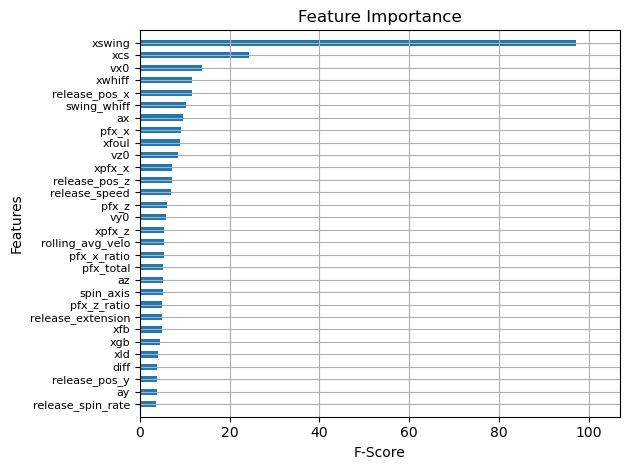

In [106]:
plt.figure(figsize=(10, 50))  # You may adjust this if needed
xgb.plot_importance(model, importance_type='gain', show_values=False, height=0.5)
plt.title('Feature Importance')
plt.xlabel('F-Score')
plt.ylabel('Features')
plt.yticks(fontsize=8)  # You can adjust fontsize if the labels are too crowded
plt.tight_layout()  # Adjust the layout to fit all labels and titles
plt.savefig('feature_importance_fb.png', dpi=300)  # Save with high resolution
plt.show()

In [107]:
# get feature importance dictionary

importance = model.get_booster().get_score(importance_type='gain')

# sort features by importance

sorted_importance = sorted(importance.items(), key=lambda item: item[1], reverse=True)

# loop to print

for feature, score in sorted_importance:
    print(f'{feature}: {score}')

xswing: 97.22757720947266
xcs: 24.248220443725586
vx0: 13.856926918029785
xwhiff: 11.606324195861816
release_pos_x: 11.551432609558105
swing_whiff: 10.27448558807373
ax: 9.675168991088867
pfx_x: 9.234726905822754
xfoul: 8.92575740814209
vz0: 8.44619083404541
xpfx_x: 7.272561073303223
release_pos_z: 7.1111297607421875
release_speed: 6.964542865753174
pfx_z: 6.16531229019165
vy0: 5.898903846740723
xpfx_z: 5.501879692077637
rolling_avg_velo: 5.442671298980713
pfx_x_ratio: 5.366792678833008
pfx_total: 5.243783950805664
az: 5.207216739654541
spin_axis: 5.123503684997559
pfx_z_ratio: 4.9851837158203125
release_extension: 4.9304986000061035
xfb: 4.851536750793457
xgb: 4.52685546875
xld: 3.9908833503723145
diff: 3.9333953857421875
release_pos_y: 3.841876745223999
ay: 3.797701120376587
release_spin_rate: 3.7000679969787598


In [108]:
# copy and keep only features

df_2023_features = df_2023[features]

# generate outcome probabilities on 2023 mlb season data

outcome_probabilities = model.predict_proba(df_2023_features)

# apply outcome probabilities back onto full df

for i, class_label in enumerate(model.classes_):
    df_2023[f'prob_{class_label}'] = outcome_probabilities[:, i]

In [109]:
# label encode linear weights to match outcome

linear_weights = linear_weights[linear_weights['description'] != 'caught_stealing_2b']
linear_weights['outcome'] = outcome_encoder.transform(linear_weights['description'])

In [110]:
linear_weight_values = linear_weights.set_index('outcome')['linear_weight']

# weighted sum of each outcome's probability * each outcome's linear weight run value

df_2023['pitch_quality'] = sum(
    df_2023[f'prob_{i}'] * linear_weight_values[i] for i in range(11)
)

In [111]:
# group by player name and pitch type for pitches a player threw more than 150 times

grouped_data = df_2023.groupby(['player_name', 'pitch_type']).filter(lambda x: len(x) > 150)

# group by player name and pitch type and get the mean pitch quality

pitch_quality_sum = grouped_data.groupby(['player_name', 'pitch_type'])['pitch_quality'].mean().reset_index()

# sort the results by pitch quality in descending order and take the top 10

top_10 = pitch_quality_sum.sort_values(by='pitch_quality', ascending=False).head(10)

# sort the results by pitch quality in ascending order and take the bottom 10

bottom_10 = pitch_quality_sum.sort_values(by='pitch_quality', ascending=True).head(10)

# print results

print("Top 10:")
print(top_10)
print("\nBottom 10:")
print(bottom_10)

Top 10:
            player_name pitch_type  pitch_quality
7       Alberto, Hanser         FA       0.090807
590     Sánchez, Aníbal         SI       0.023740
589     Sánchez, Aníbal         FF       0.020782
82       Burnes, Corbin         SI       0.019629
585       Swarmer, Matt         FF       0.018865
446     Pallante, Andre         SI       0.018804
275     Hutchison, Drew         SI       0.017763
159  Espinoza, Anderson         FF       0.017525
60      Blackburn, Paul         FF       0.017006
36        Barria, Jaime         SI       0.016851

Bottom 10:
           player_name pitch_type  pitch_quality
162    Fairbanks, Pete         FF      -0.018518
546         Smith, Joe         SI      -0.018368
602     Thompson, Ryan         SI      -0.018121
242      Helsley, Ryan         FF      -0.015509
220  Graterol, Brusdar         SI      -0.013390
152     Effross, Scott         SI      -0.013146
106       Cimber, Adam         SI      -0.012993
570   Strider, Spencer         FF     

In [112]:
# determine max and min avg pitch quality values

max_val = pitch_quality_sum['pitch_quality'].max()
min_val = pitch_quality_sum['pitch_quality'].min()

# create normalized stuff+ metric centered around 100

pitch_quality_sum['stuff_plus'] = max_val - pitch_quality_sum['pitch_quality']
mean_stuff = pitch_quality_sum['stuff_plus'].mean()
scaling_factor = 100 / mean_stuff
pitch_quality_sum['stuff_plus'] = pitch_quality_sum['stuff_plus'] * scaling_factor
pitch_quality_sum['stuff_plus'] += 100 - pitch_quality_sum['stuff_plus'].mean()

# sort by stuff plus in ascending order

sorted_pitch_quality_sum = pitch_quality_sum.sort_values(by='stuff_plus', ascending=False)

# reset index and +1 to get rank column

sorted_pitch_quality_sum = sorted_pitch_quality_sum.reset_index()
sorted_pitch_quality_sum.index = sorted_pitch_quality_sum.index + 1

# convert to int for rounding

sorted_pitch_quality_sum['stuff_plus'] = sorted_pitch_quality_sum['stuff_plus'].astype(int)

# print name, pitch type, and stuff plus top 50

sorted_pitch_quality_sum[['player_name', 'pitch_type', 'stuff_plus']].head(50)

,player_name,pitch_type,stuff_plus
1,"Fairbanks, Pete",FF,124
2,"Smith, Joe",SI,124
3,"Thompson, Ryan",SI,124
4,"Helsley, Ryan",FF,121
5,"Graterol, Brusdar",SI,119
6,"Effross, Scott",SI,118
7,"Cimber, Adam",SI,118
8,"Strider, Spencer",FF,117
9,"Alcantara, Sandy",SI,116
10,"Sewald, Paul",FF,116


In [132]:
# select top 25 rows

top_25_rows = sorted_pitch_quality_sum[['player_name', 'pitch_type', 'stuff_plus']].head(25)

# plotting rankings as a table

fig, ax = plt.subplots(figsize=(5, 6))
ax.axis('tight')
ax.axis('off')
ax.set_title('Top 25 Fastball Stuff+')
table = ax.table(cellText=top_25_rows.values,
                 colLabels=top_25_rows.columns,
                 loc='center',
                 cellLoc='center',
                 colLoc='center',
                 colWidths=[0.4, 0.2, 0.2])
plt.tight_layout()

# save fig and close

plt.savefig(r'C:\Users\adam.bloebaum\.vscode\driveline\stuff_plus_fb_v9.png', dpi=300)
plt.close()

In [27]:
# save 2022 and 2023 dfs to y drive

df.to_csv(r"Y:\departments\research_and_development\baseball_operations\clayton_goodiez\csv\2022_MLB_xfeatures_outcome_probs_stuff_plus.csv")
df_2023.to_csv(r"Y:\departments\research_and_development\baseball_operations\clayton_goodiez\csv\2023_MLB_xfeatures__outcome_probs_stuff_plus.csv")

In [139]:
# heater avg metrics function for breaking ball model

def heater_stats(df):
    grouped_df = df.groupby(['player_name', 'pitch_type'])[['release_speed', 'release_pos_x', 'release_pos_z', 'pfx_x', 'xpfx_x', 'pfx_z', 'xpfx_z', 'ax', 'ay', 'az', 'vx0', 'vy0', 'vz0', 'release_spin_rate', 'release_extension', 'spin_axis']].mean().reset_index()
    idx = grouped_df.groupby(['player_name'])['release_speed'].transform(max) == grouped_df['release_speed']
    heater_df = grouped_df[idx]
    heater_df = heater_df.groupby('player_name').head(1).reset_index(drop=True)
    final_df = heater_df.rename(columns={col: f'fb_{col}' if col != 'player_name' else col for col in heater_df.columns})
    return final_df

heaters_2022 = heater_stats(df)

heaters_2022[heaters_2022['player_name'] == 'Fairbanks, Pete']

,player_name,fb_pitch_type,fb_release_speed,fb_release_pos_x,fb_release_pos_z,fb_pfx_x,fb_xpfx_x,fb_pfx_z,fb_xpfx_z,fb_ax,fb_ay,fb_az,fb_vx0,fb_vy0,fb_vz0,fb_release_spin_rate,fb_release_extension,fb_spin_axis
210,"Fairbanks, Pete",FF,98.812,-0.283244,6.986844,-0.001911,0.010514,1.700844,1.649934,-0.180282,34.351438,-6.557538,0.620808,-143.582278,-9.776687,2505.422222,6.612444,188.422222


In [134]:
# group by pitcher and pitch type

pp = df_2023.groupby(['player_name', 'pitch_type'])

# calculate sum of delta run expectancy and count of pitches for each pitcher's pitch

rv = pp.agg(total_delta_run_exp=('delta_run_exp', 'sum'),
                      total_pitches=('delta_run_exp', 'count'))

# calculate run value per 100 pitches

rv['run_value_per_100_pitches'] = (rv['total_delta_run_exp'] / rv['total_pitches']) * 100

# filter for pitches thrown at least 200 times and sort

rv = rv[rv['total_pitches'] > 150]
rv = rv.sort_values(by='run_value_per_100_pitches')

# merge with sorted pitch quality sum on player name and pitch type

model_validation_df = pd.merge(sorted_pitch_quality_sum, rv, on=['player_name', 'pitch_type'], how='left')

c:\Users\adam.bloebaum\AppData\Local\miniconda3\envs\driveline\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


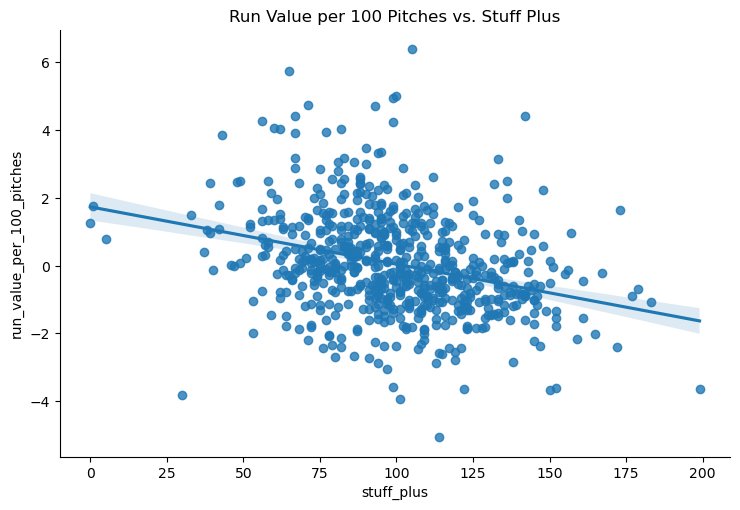

In [135]:
# scatter plot with a regression line

sns.lmplot(x='stuff_plus', y='run_value_per_100_pitches', data=model_validation_df, aspect=1.5)
plt.title('Run Value per 100 Pitches vs. Stuff Plus')
plt.savefig(r'C:\Users\adam.bloebaum\.vscode\driveline\validation_02.png', dpi=300)
plt.savefig('run_value_validation_plot.png', dpi=300)
plt.show()

In [136]:
# correlation coefficient

correlation = model_validation_df['stuff_plus'].corr(model_validation_df['run_value_per_100_pitches'])
print(f"Correlation Coefficient: {correlation}")


from scipy import stats
from sklearn.metrics import mean_squared_error, r2_score

slope, intercept, r_value, p_value, std_err = stats.linregress(model_validation_df['stuff_plus'], model_validation_df['run_value_per_100_pitches'])
predicted_values = slope * model_validation_df['stuff_plus'] + intercept

# mse and rmse

mse = mean_squared_error(model_validation_df['run_value_per_100_pitches'], predicted_values)
rmse = np.sqrt(mse)
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")

# rsquared

r_squared = r2_score(model_validation_df['run_value_per_100_pitches'], predicted_values)
print(f"R-squared: {r_squared}")

Correlation Coefficient: -0.3056009885904426
Mean Squared Error: 2.049051755127098
Root Mean Squared Error: 1.4314509265521813
R-squared: 0.0933919642274561
